ДЗ Бернатович 04.01.2022
Работа с временными рядами.
    
Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
from sklearn.multiclass import OneVsRestClassifier
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
from itertools import product
import scipy.stats as scs
from scipy.optimize import minimize
from scipy import stats
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.rcParams['figure.figsize'] = 17, 6
plt.rcParams['font.size'] = 12

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

In [163]:
dataset=pd.read_csv("accidental-deaths-in-usa-monthly.csv", index_col=['Month'], parse_dates=['Month'])

In [164]:
df=pd.read_csv("accidental-deaths-in-usa-monthly.csv")

In [165]:
dataset

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017
...,...
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070


In [166]:
dataset.rename(columns = {'Accidental deaths in USA: monthly, 1973 ? 1978' : 'Accidental_deaths'}, inplace = True)

Text(0, 0.5, 'Accidental deaths in USA')

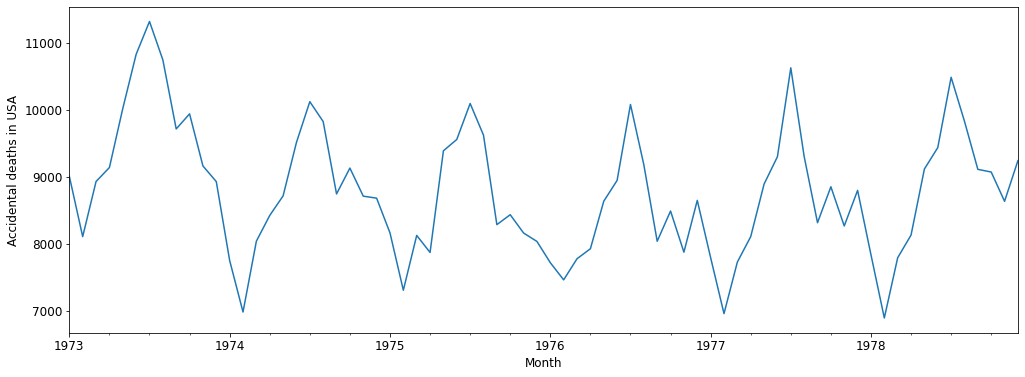

In [167]:
dataset['Accidental_deaths'].plot()
plt.ylabel('Accidental deaths in USA')

На графике видна сезонность, т.е. ряд должен быть нестационарным.
Проверим это предположение с помощью теста Дики-Фуллера.

In [168]:
p = sm.tsa.stattools.adfuller(dataset['Accidental_deaths'])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.3f}')

Критерий Дики-Фуллера: p-value=0.102


ряд нестационарен

Проведём сезонное дифференцирование. Длина сезона в нашем случае равна 12. 

Критерий Дики-Фуллера: p-value=0.015


[]

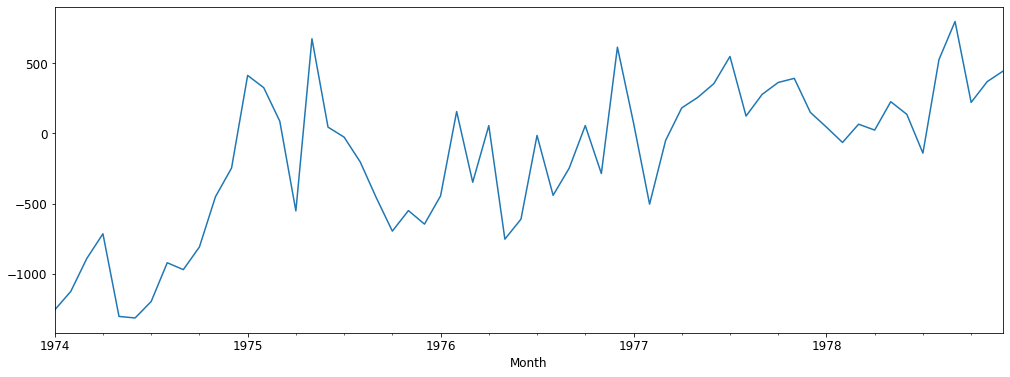

In [169]:
dataset['boxcox_shifted_S'] = dataset.Accidental_deaths - dataset.Accidental_deaths.shift(12)

p = sm.tsa.stattools.adfuller(dataset.boxcox_shifted_S[12:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.3f}')

dataset.boxcox_shifted_S[12:].plot()
plt.plot()

Дополним обычным дифференцированием.

Критерий Дики-Фуллера: p-value=0.000


[]

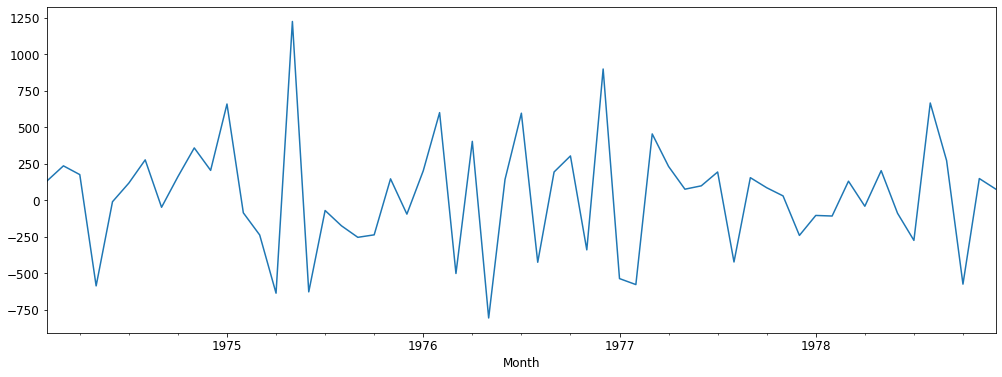

In [170]:
dataset['boxcox_shifted'] = dataset.boxcox_shifted_S - dataset.boxcox_shifted_S.shift(1)

p = sm.tsa.stattools.adfuller(dataset.boxcox_shifted[13:])[1]
print(f'Критерий Дики-Фуллера: p-value={p:.3f}')

dataset.boxcox_shifted[13:].plot()
plt.plot()

Критерий Дики-Фуллера говорит, что такой ряд является стационарным.

### Подбор параметров для модели ARIMA

In [215]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [222]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset['Accidental_deaths'], order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except ValueError:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1493.7967008341236
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1243.3683320087437
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:911.8542383873889
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:696.5574562258784
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:925.739597969573
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:864.9534958300952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:711.2902709890382
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:698.5543906167286
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1424.6302061597394
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1172.4012810895263
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:871.1396675203894
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:670.9912496281235
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:910.484953335361
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:838.8999589603729
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:704.8080053870392
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:672.5061890163278
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1123.2886710443101
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:894.4660903337833
ARIMA(0

Согласно полученному выводу, SARIMAX(0, 1, 1)x(0, 1, 1, 12) получает наименьший показатель AIC (651.79). 
Следовательно, эти параметры можно считать оптимальными.

In [254]:
#Добавим оптимальные параметры в модель SARIMAX:
mod = sm.tsa.statespace.SARIMAX(dataset['Accidental_deaths'],
order=(0, 1, 1),
seasonal_order=(0, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6635      0.125     -5.329      0.000      -0.908      -0.419
ma.S.L12      -0.4254      0.178     -2.390      0.017      -0.774      -0.077
sigma2      9.959e+04   1.93e+04      5.166      0.000    6.18e+04    1.37e+05


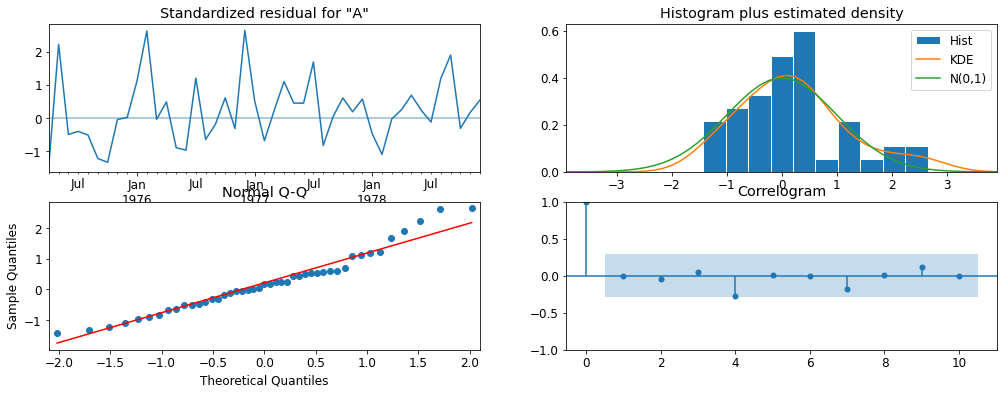

In [255]:
results.plot_diagnostics() #диагностика модели
plt.show()

На верхнем правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Это хороший признак того, что остатки нормально распределены.


График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.


Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.


Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данного временного ряда.

In [256]:
pred = results.get_prediction(start=pd.to_datetime('1973-01-01'), dynamic=False)
pred_ci = pred.conf_int()

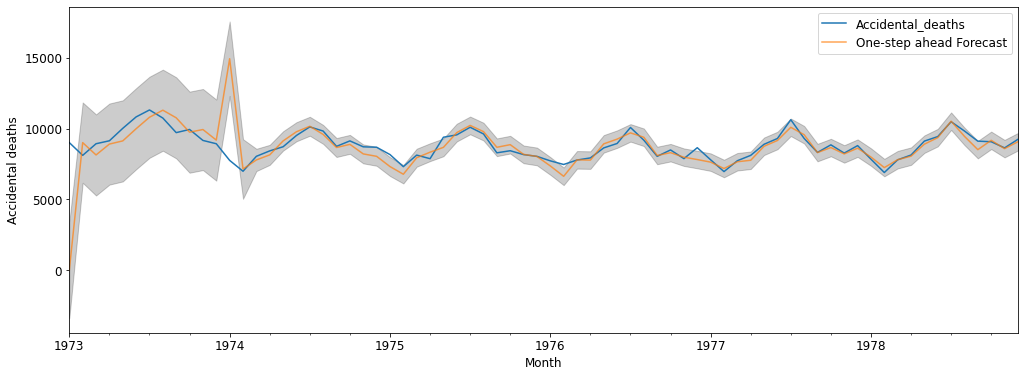

In [257]:
ax = dataset['Accidental_deaths'].plot()
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Accidental deaths')
plt.legend()
plt.show()

In [258]:
y_forecasted = pred.predicted_mean
y_truth = dataset['Accidental_deaths']['1973-01-01':] 
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2012938.73


In [ ]:
MSE прогнозов на один шаг вперед дает значение 2012938.73

In [260]:
# Получить прогноз на 24 шага вперёд
pred_uc = results.get_forecast(steps=24)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

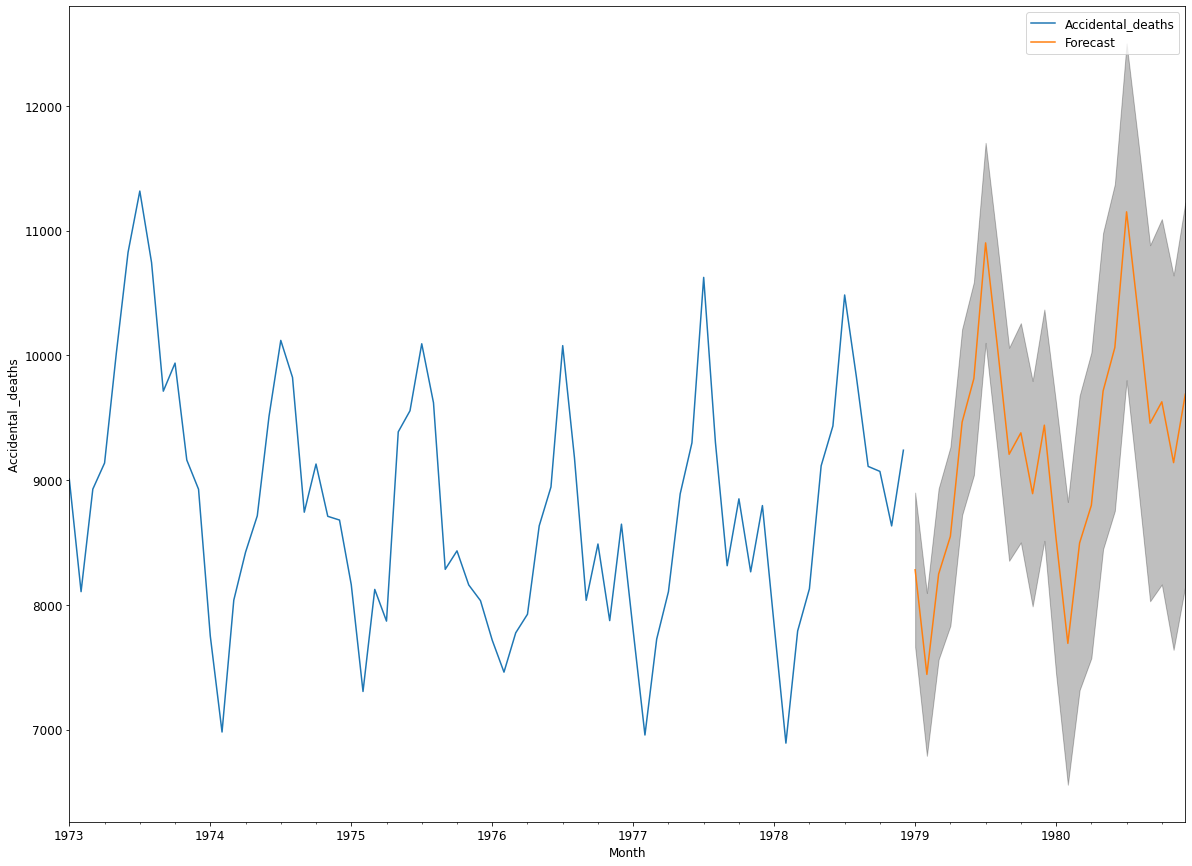

In [261]:
ax = dataset['Accidental_deaths'].plot(figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Accidental deaths')
plt.legend()
plt.show()

### Прогнозирование временных рядов с помощью Prophet

In [94]:
df.dtypes

Month                                             object
Accidental deaths in USA: monthly, 1973 ? 1978     int64
dtype: object

In [96]:
df['Month'] = pd.DatetimeIndex(df['Month'])

In [97]:
df.dtypes

Month                                             datetime64[ns]
Accidental deaths in USA: monthly, 1973 ? 1978             int64
dtype: object

In [133]:
df=df.rename(columns={'Month': 'ds', 'Accidental deaths in USA: monthly, 1973 ? 1978': 'y'})
df.head(5)

,ds,y
0,1973-01-01,9007
1,1973-02-01,8106
2,1973-03-01,8928
3,1973-04-01,9137
4,1973-05-01,10017


In [134]:
my_model = Prophet(interval_width=0.95) #укажем диапазон интервала неопределенности с помощью параметра interval_width

In [135]:
my_model.fit(df)

00:31:34 - cmdstanpy - INFO - Chain [1] start processing
00:31:35 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
future_dates = my_model.make_future_dataframe(periods=24, freq='MS') #Prophet сгенерирует 24 метоки времени
future_dates.tail()

,ds
91,1980-08-01
92,1980-09-01
93,1980-10-01
94,1980-11-01
95,1980-12-01


In [137]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#ds: временная метка прогнозируемого значения.
#yhat: прогнозируемое значение метрики (в статистике обозначение yhat традиционно используется для представления прогнозируемых значений y).
#yhat_lower: нижняя граница прогнозов.
#yhat_upper: высшая граница прогнозов.

,ds,yhat,yhat_lower,yhat_upper
91,1980-08-01,10233.348140,9777.194679,10754.189157
92,1980-09-01,9246.297815,8722.249182,9813.210488
93,1980-10-01,9745.338886,9206.226486,10264.605471
94,1980-11-01,9067.396860,8516.514854,9633.198412
95,1980-12-01,9705.197455,9171.348659,10270.295585


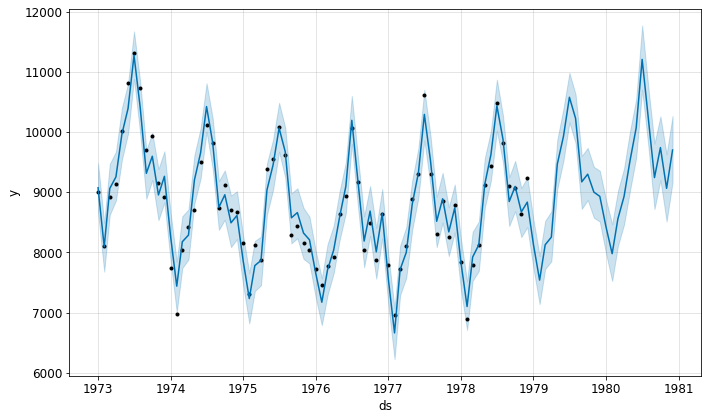

In [138]:
my_model.plot(forecast, uncertainty=True);

Prophet показывает значения временных рядов (черные точки), прогнозируемые значения (синяя линия) и интервалы неопределенности прогнозов (синие заштрихованные области).

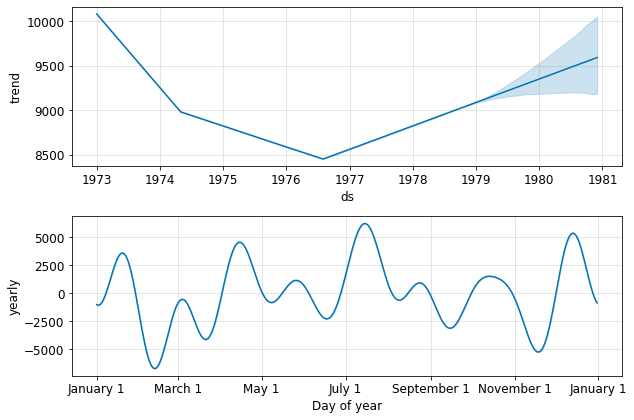

In [139]:
my_model.plot_components(forecast); #компоненты прогнозов

### NeuralProphet 

In [156]:
from neuralprophet import NeuralProphet

In [157]:
model = NeuralProphet()
metrics = model.fit(df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 668
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (5) is too small than the required number for the learning rate finder (205). The results might not be optimal.


Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.625% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.625% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 5it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


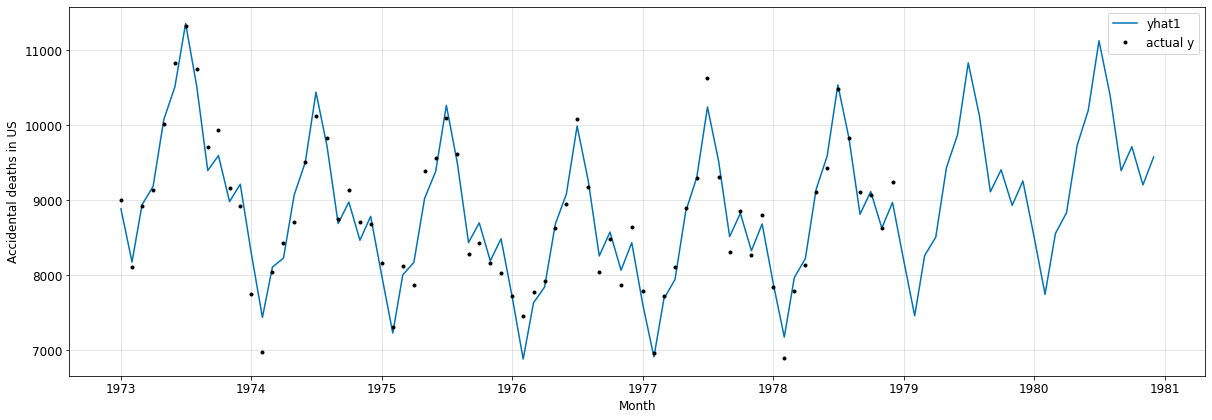

In [152]:
future = model.make_future_dataframe(df, periods=24, n_historic_predictions=len(df))
forecast = model.predict(future)
fig, ax = plt.subplots(figsize=(17,6))
model.plot(forecast, xlabel="Month", ylabel="Accidental deaths in US", ax=ax);


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


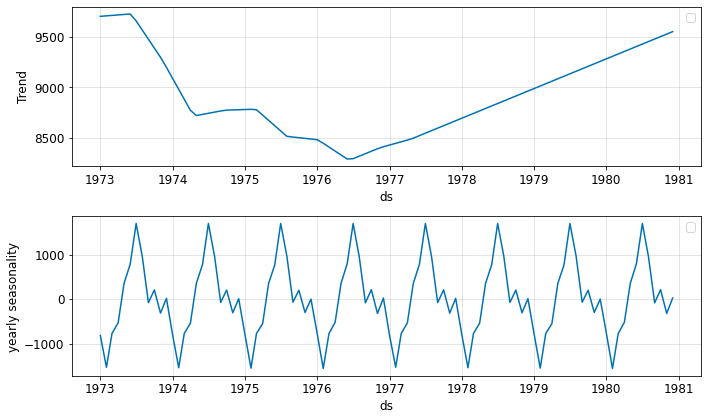

In [155]:
 fig_comp = model.plot_components(forecast)

Таким образом, мы можем говорить о небольшом увеличении смертей в результате несчастного случая.

In [ ]:
#можно еще посмотреть
Sktime
Darts
Merlion
Pytorch-Forecasting
Grey Kite
Kats